# Optimization of neural network weights

## Pre-Processing

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

data = pd.read_csv("/content/diabetes.csv")
#data = pd.read_csv("/content/diabetes (1).csv")
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [18]:
# 2. Initial exploration
print("\n=== Data Info ===")
print(data.info())
print("\n=== Descriptive Statistics ===")
print(data.describe())
print("\n=== Missing Values ===")
print(data.isnull().sum())


=== Data Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None

=== Descriptive Statistics ===
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531  

In [19]:
# 2. Identify columns with zero values that are likely invalid
cols_zero = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# 3. Replace zeros with NaN
data[cols_zero] = data[cols_zero].replace(0, np.nan)

# 4. Fill missing values with the median
data[cols_zero] = data[cols_zero].apply(lambda col: col.fillna(col.median()))





In [20]:
# 5. Remove outliers using IQR method
for col in cols_zero:
    q1 = data[col].quantile(0.25)
    q3 = data[col].quantile(0.75)
    iqr = q3 - q1
    upper = q3 + 1.5 * iqr
    lower = q1 - 1.5 * iqr
    data[col] = np.where(data[col] > upper, upper,
                 np.where(data[col] < lower, lower, data[col]))

# 6. Confirm no missing values remain
print("\n✅ Missing values after cleaning:")
print(data.isnull().sum())


✅ Missing values after cleaning:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


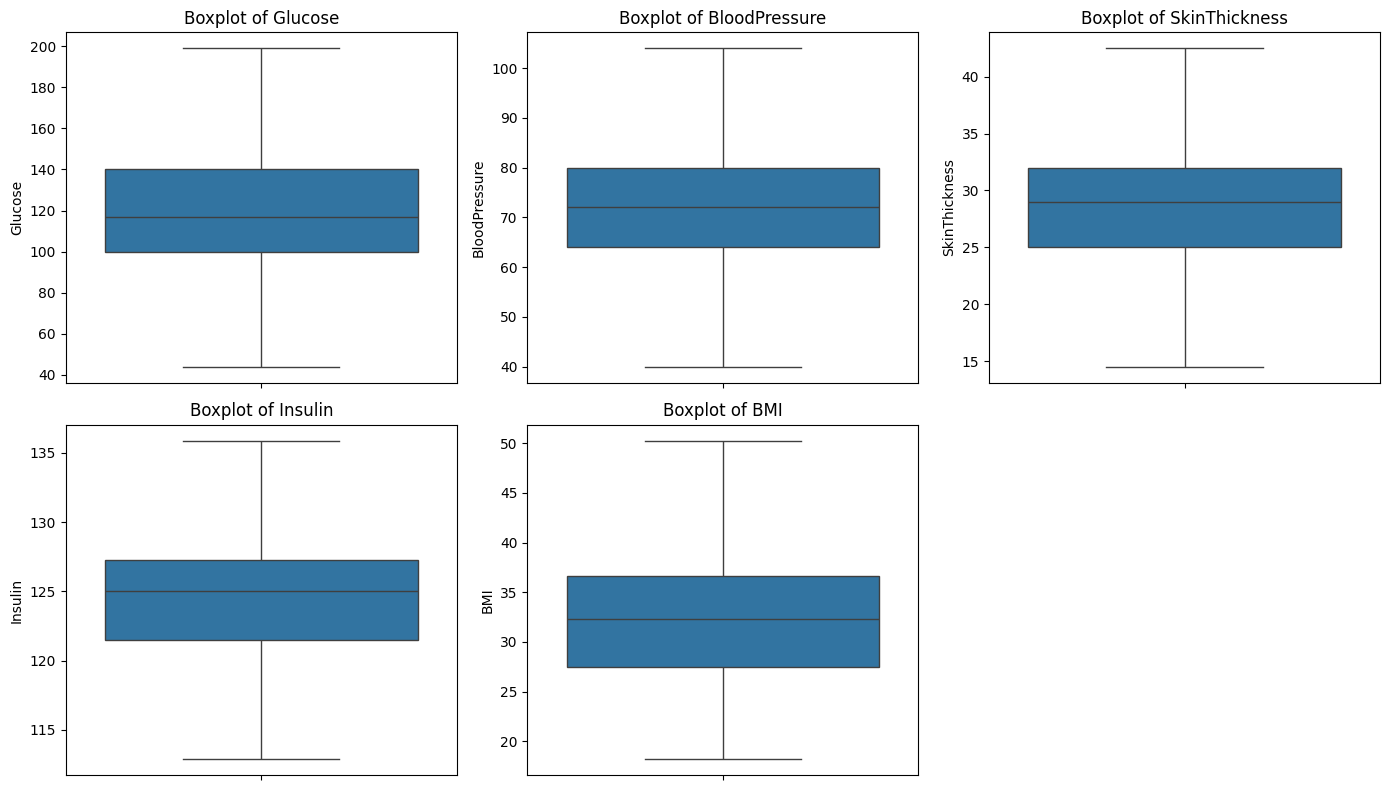

In [22]:
# 6. Boxplots for feature distributions
plt.figure(figsize=(14, 8))
for i, col in enumerate(cols_zero, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=data[col])
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()


<Figure size 1200x1000 with 0 Axes>

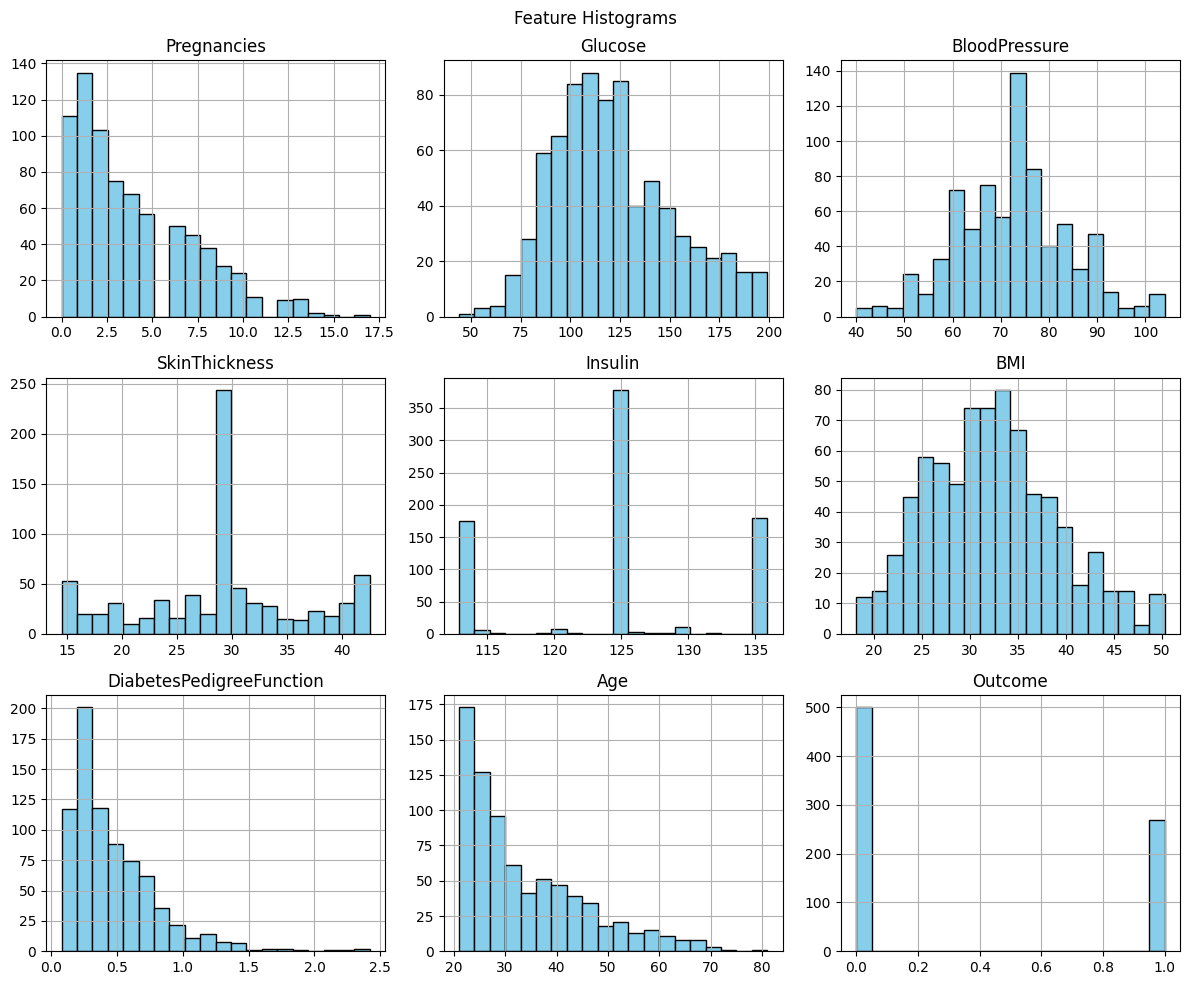

In [24]:
# 7. Histograms of all features
plt.figure(figsize=(12, 10))
data.hist(bins=20, figsize=(12, 10), color='skyblue', edgecolor='black')
plt.suptitle("Feature Histograms")
plt.tight_layout()
plt.show()

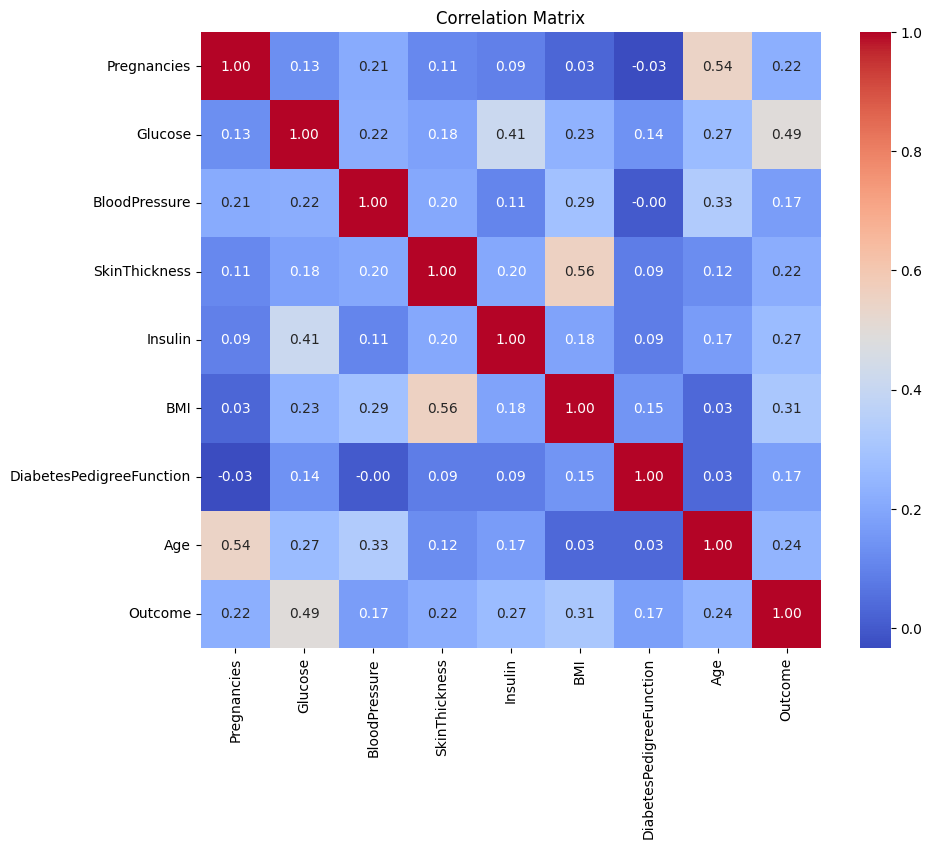

In [25]:
# 8. Correlation matrix
corr = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


In [28]:
# 10. Feature scaling
y = data['Outcome']
X = data.drop('Outcome', axis=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 11. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.4, stratify=y, random_state=42
)

In [29]:
# 12. Final summary
print(f"\n📊 Final Data Summary:")
print(f"Train set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Train class ratio (1s): {np.mean(y_train):.2f}")
print(f"Test class ratio (1s): {np.mean(y_test):.2f}")


📊 Final Data Summary:
Train set shape: (460, 8)
Test set shape: (308, 8)
Train class ratio (1s): 0.35
Test class ratio (1s): 0.35


## Neural Network

In [30]:
# Part 2: Neural Network & Optimizer Comparison
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, Adagrad, Adadelta, Nadam
from tensorflow.keras.callbacks import EarlyStopping

# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')

# Function to build model
def build_nn(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.1),
        Dense(1, activation='sigmoid')
    ])
    return model

# Optimizers dict
optimizers = {
    'Adam': Adam(learning_rate=0.001),
    'RMSprop': RMSprop(learning_rate=0.001),
    'Adagrad': Adagrad(learning_rate=0.01),
    'Adadelta': Adadelta(learning_rate=1.0),
    'Nadam': Nadam(learning_rate=0.001)
}

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Store histories and results
histories = {}
results = {}

for name, opt in optimizers.items():
    model = build_nn(X_train.shape[1])
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(
        X_train, y_train,
        epochs=50, batch_size=32,
        validation_split=0.1,
        callbacks=[early_stop],
        verbose=0
    )
    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    results[name] = {'loss': loss, 'accuracy': acc}
    histories[name] = history.history
    print(f"{name}: Test Loss={loss:.4f}, Test Accuracy={acc:.4f}")

# Summary DataFrame (sorted by accuracy descending)
df_results = pd.DataFrame(results).T.sort_values(by='accuracy', ascending=False)
print("\n📊 Comparison of Optimizers:")
print(df_results)

# Print best optimizer
best = df_results.iloc[0]
print(f"\n✅ Best Optimizer: {best.name} → Accuracy: {best['accuracy']:.4f}, Loss: {best['loss']:.4f}")




/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Adam: Test Loss=0.5025, Test Accuracy=0.7500
RMSprop: Test Loss=0.5028, Test Accuracy=0.7403
Adagrad: Test Loss=0.4833, Test Accuracy=0.7695
Adadelta: Test Loss=0.5010, Test Accuracy=0.7338
Nadam: Test Loss=0.4936, Test Accuracy=0.7597

📊 Comparison of Optimizers:
              loss  accuracy
Adagrad   0.483285  0.769481
Nadam     0.493560  0.759740
Adam      0.502485  0.750000
RMSprop   0.502819  0.740260
Adadelta  0.500991  0.733766

✅ Best Optimizer: Adagrad → Accuracy: 0.7695, Loss: 0.4833


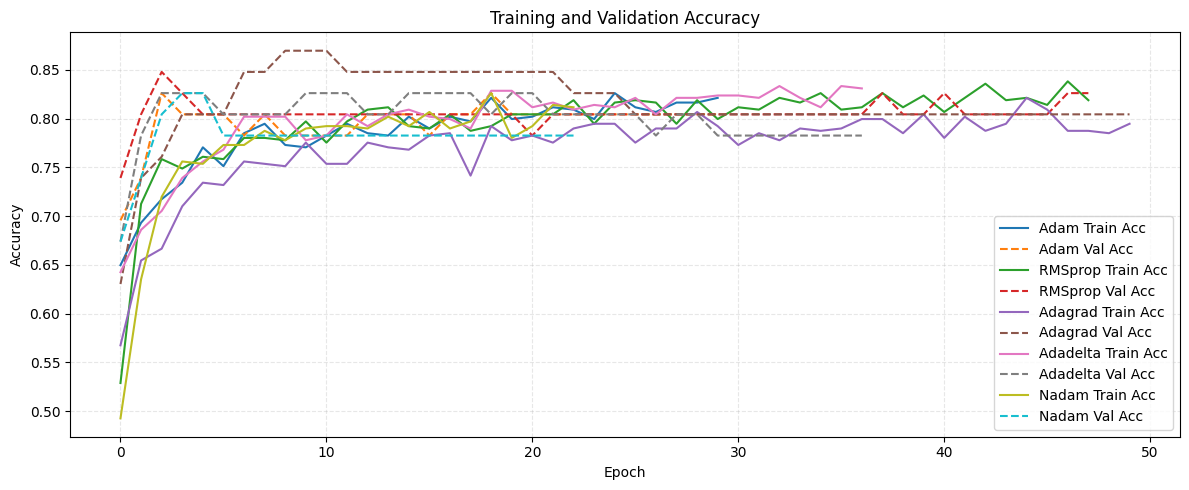

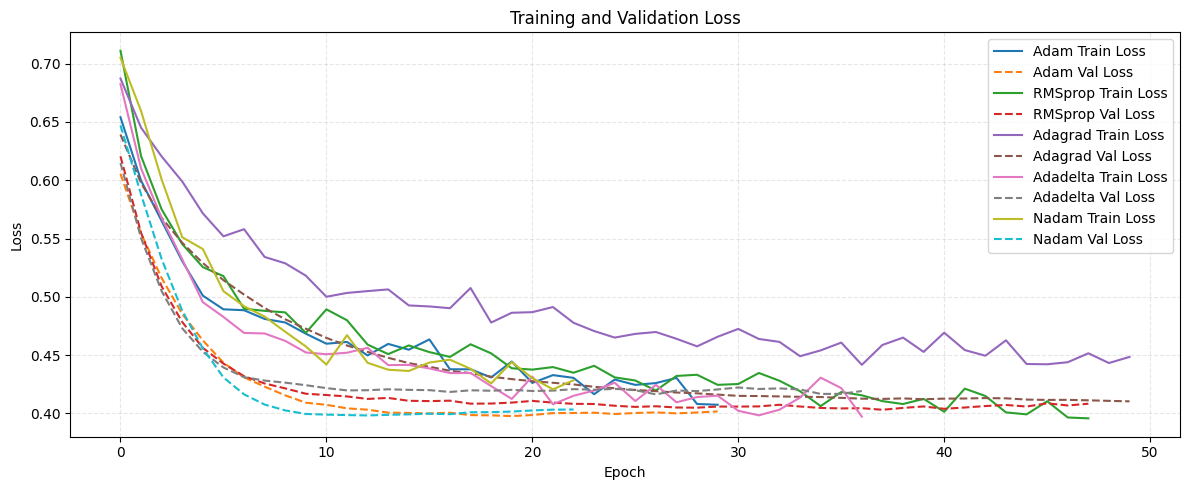

In [31]:
# Plot training & validation accuracy
plt.figure(figsize=(12, 5))
for name, hist in histories.items():
    plt.plot(hist['accuracy'], label=f'{name} Train Acc')
    plt.plot(hist['val_accuracy'], '--', label=f'{name} Val Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Plot training & validation loss
plt.figure(figsize=(12, 5))
for name, hist in histories.items():
    plt.plot(hist['loss'], label=f'{name} Train Loss')
    plt.plot(hist['val_loss'], '--', label=f'{name} Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## Genatic Algorithm


Generation 1
Max Fitness: 0.6325
Generation 2
Max Fitness: 0.7037
Generation 3
Max Fitness: 0.7037
Generation 4
Max Fitness: 0.7037
Generation 5
Max Fitness: 0.7037
Generation 6
Max Fitness: 0.7037
Generation 7
Max Fitness: 0.7238
Generation 8
Max Fitness: 0.7262
Generation 9
Max Fitness: 0.7900
Generation 10
Max Fitness: 0.8025
Generation 11
Max Fitness: 0.8025
Generation 12
Max Fitness: 0.8025
Generation 13
Max Fitness: 0.8025
Generation 14
Max Fitness: 0.8075
Generation 15
Max Fitness: 0.8163
Generation 16
Max Fitness: 0.8163
Generation 17
Max Fitness: 0.8275
Generation 18
Max Fitness: 0.8275
Generation 19
Max Fitness: 0.8275
Generation 20
Max Fitness: 0.8275
Generation 21
Max Fitness: 0.8275
Generation 22
Max Fitness: 0.8375
Generation 23
Max Fitness: 0.8375
Generation 24
Max Fitness: 0.8413
Generation 25
Max Fitness: 0.8413
Generation 26
Max Fitness: 0.8425
Generation 27
Max Fitness: 0.8462
Generation 28
Max Fitness: 0.8462
Generation 29
Max Fitness: 0.8525
Generation 30
Max Fitne

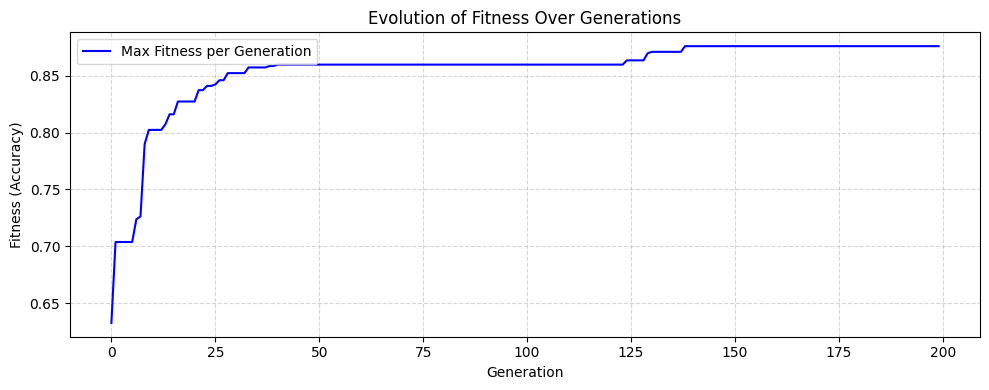

In [39]:
import numpy as np
import random
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification

# ========== 1. ANN Definition ==========
class ANN(Sequential):
    def __init__(self, child_weights=None):
        super().__init__()
        self.add(Input(shape=(8,)))
        self.add(Dense(32, activation='relu'))
        self.add(Dense(16, activation='relu'))
        self.add(Dense(8, activation='relu'))
        self.add(Dense(4, activation='relu'))
        self.add(Dense(1, activation='sigmoid'))

        if child_weights is not None:
            self.layers[0].set_weights([child_weights[0], np.ones(32)])
            self.layers[1].set_weights([child_weights[1], np.zeros(16)])
            self.layers[2].set_weights([child_weights[2], np.zeros(8)])
            self.layers[3].set_weights([child_weights[3], np.zeros(4)])
            self.layers[4].set_weights([child_weights[4], np.zeros(1)])

    def forward_propagation(self, X, y):
        predict_label = self.predict(X, verbose=0)
        self.fitness = accuracy_score(y, np.round(predict_label).astype(int))

    def compile_train(self, epochs, X, y):
        self.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
        self.fit(X, y, epochs=epochs, verbose=0)

# ========== 2. Crossover Function ==========
def crossover(nn1, nn2):
    nn1_weights = [layer.get_weights()[0] for layer in nn1.layers]
    nn2_weights = [layer.get_weights()[0] for layer in nn2.layers]
    child_weights = []

    for i in range(len(nn1_weights)):
        split = random.randint(0, nn1_weights[i].shape[1] - 1)
        new_weights = np.copy(nn1_weights[i])
        new_weights[:, split:] = nn2_weights[i][:, split:]
        child_weights.append(new_weights)

    mutation(child_weights)
    return ANN(child_weights)

# ========== 3. Mutation Function ==========
def mutation(child_weights):
    for i in range(len(child_weights)):
        if random.uniform(0, 1) < 0.1:
            mutation_factor = np.random.normal(loc=0.0, scale=0.1, size=child_weights[i].shape)
            child_weights[i] += mutation_factor

# ========== 4. Genetic Algorithm ==========
def genetic_algorithm(X_train, y_train, X_test, y_test, population_size=20, generations=200, top_k=5):
    networks = [ANN() for _ in range(population_size)]
    max_fitness = 0
    optimal_weights = []
    fitness_history = []

    for generation in range(generations):
        print(f"Generation {generation + 1}")
        for net in networks:
            net.forward_propagation(X_train, y_train)

        networks = sorted(networks, key=lambda x: x.fitness, reverse=True)

        if networks[0].fitness > max_fitness:
            max_fitness = networks[0].fitness
            optimal_weights = [layer.get_weights()[0] for layer in networks[0].layers]

        fitness_history.append(max_fitness)

        next_gen = networks[:top_k]
        while len(next_gen) < population_size:
            parent1, parent2 = random.sample(networks[:top_k], 2)
            child = crossover(parent1, parent2)
            next_gen.append(child)

        networks = next_gen
        print(f"Max Fitness: {max_fitness:.4f}")

    best_ann = ANN(child_weights=optimal_weights)
    best_ann.compile_train(epochs=50, X=X_train, y=y_train)
    pred = best_ann.predict(X_test, verbose=0)
    print("✅ Final Test Accuracy: %.2f" % accuracy_score(y_test, np.round(pred).astype(int)))

    # Plot Fitness Over Generations
    plt.figure(figsize=(10, 4))
    plt.plot(fitness_history, label="Max Fitness per Generation", color="blue")
    plt.xlabel("Generation")
    plt.ylabel("Fitness (Accuracy)")
    plt.title("Evolution of Fitness Over Generations")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ========== 5. Generate & Run ==========
X, y = make_classification(n_samples=1000, n_features=8, n_informative=6, n_redundant=2, random_state=42)
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

genetic_algorithm(X_train, y_train, X_test, y_test)


# MCTS-GA

### Application of MCTS to GA for optimizing search


In [41]:
import numpy as np
import random
import tensorflow as tf
from sklearn.metrics import accuracy_score
from joblib import Parallel, delayed
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

class Node():
    def __init__(self, state, parent=None):
        self.state = state
        self.visit_count = 0
        self.score_total = 0
        self.parent = parent
        self.child_list = []

    def update(self, score):
        self.visit_count += 1
        self.score_total += score

    def children(self):
        return self.child_list

    def N_values(self):
        return [c.visit_count for c in self.children()]

    def Q_values(self):
        children = self.children()
        Q = [c.score_total / (c.visit_count + 1) for c in children]
        return Q

    def is_leaf(self):
        return len(self.child_list) == 0

class MCTS():
    def __init__(self, model, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        self.model = model

    def uct(self, node, exploration_constant=2):
        Q = np.array(node.Q_values())
        N = np.array(node.N_values())
        U = Q + np.sqrt(exploration_constant * np.log(node.visit_count + 1) / (N + 1))
        return node.children()[np.argmax(U)]

    def backtrack(self, node):
        score = node.score_total
        node = node.parent
        while node:
            node.update(score)
            node = node.parent

    def fitness(self, state):
        W = np.array([])
        for i, layer in enumerate(self.model.layers):
            layer_w = layer.get_weights()
            layer_w[0] = state[i]
            W = np.append(W, layer_w)
        self.model.set_weights(W)
        _, fitness = self.model.evaluate(self.X_train, self.y_train, verbose=0)
        return fitness

    def init_root(self):
        template = []
        for layer in self.model.layers:
            template.append(layer.get_weights()[0])
        return Node(template)

    def genetic_action(self, node):
        def generate_population(state):
            child_population = []
            for i, weights in enumerate(state):
                r = np.random.uniform(-1, 1, size=weights.shape[1])
                for j in range(weights.shape[1]):
                    weights[:, j] += r[j]
                new_weight = state.copy()
                new_weight[i] = weights
                child_population.append(new_weight)
            child_population.append(state)
            return child_population

        def tournament_selection(population, k):
            best = None
            ind = np.random.choice(np.arange(len(population)), k, replace=False)
            for i in ind:
                if best is None or self.fitness(population[i]) > self.fitness(best):
                    best = population[i]
            return best

        def crossover(c_prob, individual_1, individual_2):
            if np.random.rand() < c_prob:
                for i, l_w in enumerate(individual_1):
                    crx_index = np.random.choice(np.arange(len(l_w)))
                    individual_1[i][:crx_index], individual_2[i][:crx_index] = individual_2[i][:crx_index], individual_1[i][:crx_index]
            return individual_1, individual_2

        def mutation(mu, individual_1, individual_2):
            if np.random.rand() < mu:
                for i, l_w in enumerate(individual_1):
                    index = np.random.choice(np.arange(len(l_w)))
                    individual_1[i][index], individual_2[i][index] = individual_2[i][index], individual_1[i][index]
            return [individual_1, individual_2][np.random.randint(2)]

        state = node.state
        population = generate_population(state)
        children = []
        for _ in range(len(population)):
            individual_2 = tournament_selection(population, 3)
            cross_children = crossover(0.75, state, individual_2)
            mutated_child = mutation(0.25, *cross_children)
            children.append(mutated_child)
        return list(map(Node, children, [node] * len(children)))

    def rollout(self, node):
        def mutate_population(mutation_rate, state):
            W = []
            for weights_list in state:
                weights_list += np.random.normal(0, mutation_rate, size=weights_list.shape)
                W.append(weights_list)
            return W

        def select_survivors(parents, offspring, elite_ratio):
            all_solutions = np.vstack((parents, offspring))
            all_fitness = np.array([self.fitness(solution) for solution in all_solutions])
            elite_size = int(elite_ratio * all_solutions.shape[0])
            elite_idx = np.argsort(all_fitness)[::-1][:elite_size]
            survivors = all_solutions[elite_idx]
            return survivors

        def evolutionary_rollout(node, lambda_=5, sampling_frequency=5, max_iterations=10, mutation_rate=0.01, rate_of_change=0.6, elite_ratio=0.8):
            parent = node.state.copy()
            k = 0
            while k < max_iterations:
                counter = 0
                for n in range(sampling_frequency):
                    offsprings = []
                    for l in range(lambda_):
                        offspring = mutate_population(mutation_rate, parent)
                        offsprings.append(offspring)
                        parent_fitness = self.fitness(parent)
                        offspring_fitness = self.fitness(offspring)
                        if offspring_fitness > parent_fitness:
                            counter += 1
                    parents = select_survivors(parent, offsprings, elite_ratio)
                    k += 1
                if counter < (n * lambda_ / 5):
                    mutation_rate = (1 - rate_of_change) * mutation_rate
                else:
                    mutation_rate = (1 + rate_of_change) * mutation_rate
                final_fitness = [self.fitness(parent) for parent in parents]
                best_fitness = np.argmax(final_fitness)
            return parents[best_fitness], final_fitness[best_fitness]

        state, score = evolutionary_rollout(node)
        if score > node.score_total:
            print("Better aged solution found:")
            node.state = state
            node.score_total = score
        return node

def nn(input_shape, weights=None):
    inputs = Input(shape=(input_shape,))
    x = Dense(32, activation='relu')(inputs)
    x = Dense(16, activation='relu')(x)
    x = Dense(8, activation='relu')(x)
    x = Dense(4, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)

    if weights:
        # Set weights after the model is built
        model.layers[1].set_weights([weights[0], np.ones(32)])
        model.layers[2].set_weights([weights[1], np.zeros(16)])
        model.layers[3].set_weights([weights[2], np.zeros(8)])
        model.layers[4].set_weights([weights[3], np.zeros(4)])
        model.layers[5].set_weights([weights[4], np.zeros(1)])

    return model

# Assuming X_train, y_train, X_test, y_test are predefined
genetic_algorithm(X_train, y_train, X_test, y_test)

def compute_fitness(model, X_train, y_train):
    predictions = model.predict(X_train)
    fitness = accuracy_score(y_train, np.round(predictions).astype(int))
    return fitness

def crossover(weights1, weights2):
    child_weights = []
    for w1, w2 in zip(weights1, weights2):
        split = random.randint(0, w1.shape[1] - 1)
        new_weights = np.concatenate((w1[:, :split], w2[:, split:]), axis=1)
        child_weights.append(new_weights)
    mutation(child_weights)
    return child_weights

def mutation(weights):
    mutation_rate = 0.1
    for i in range(len(weights)):
        if random.uniform(0, 1) < mutation_rate:
            mutation_factor = np.random.normal(loc=0.0, scale=0.1, size=weights[i].shape)
            weights[i] += mutation_factor

def genetic_algorithm(X_train, y_train, X_test, y_test, population_size=20, generations=35, top_k=5):
    input_shape = X_train.shape[1]
    population = [nn(input_shape) for _ in range(population_size)]
    max_fitness = 0
    optimal_weights = None

    def evaluate_model(model):
        model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
        early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
        model.fit(X_train, y_train, epochs=10, verbose=0, callbacks=[early_stopping])
        fitness = compute_fitness(model, X_train, y_train)
        return model, fitness

    for generation in range(generations):
        print(f"Generation: {generation + 1}")
        fitness_scores = Parallel(n_jobs=-1)(delayed(evaluate_model)(model) for model in population)

        fitness_scores.sort(key=lambda x: x[1], reverse=True)
        best_model, best_fitness = fitness_scores[0]
        if best_fitness > max_fitness:
            max_fitness = best_fitness
            optimal_weights = [layer.get_weights()[0] for layer in best_model.layers if layer.weights]

        next_generation = [model for model, _ in fitness_scores[:top_k]]

        while len(next_generation) < population_size:
            parents = random.sample(next_generation, 2)
            parent1_weights = [layer.get_weights()[0] for layer in parents[0].layers if layer.weights]
            parent2_weights = [layer.get_weights()[0] for layer in parents[1].layers if layer.weights]
            child_weights = crossover(parent1_weights, parent2_weights)
            child_model = nn(input_shape, weights=child_weights)
            next_generation.append(child_model)

        population = next_generation
        print(f"Max Fitness in Generation {generation + 1}: {max_fitness}")

    best_model = nn(input_shape, weights=optimal_weights)
    best_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
    best_model.fit(X_train, y_train, epochs=50, verbose=0, callbacks=[early_stopping])
    predictions = best_model.predict(X_test)
    print('Test Accuracy: %.2f' % accuracy_score(y_test, np.round(predictions).astype(int)))

# Assuming X_train, y_train, X_test, y_test are predefined
genetic_algorithm(X_train, y_train, X_test, y_test)


Generation: 1
Max Fitness in Generation 1: 0.91375
Generation: 2


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Max Fitness in Generation 2: 0.93625
Generation: 3
Max Fitness in Generation 3: 0.94875
Generation: 4
Max Fitness in Generation 4: 0.955
Generation: 5
Max Fitness in Generation 5: 0.96375
Generation: 6
Max Fitness in Generation 6: 0.9675
Generation: 7
Max Fitness in Generation 7: 0.97875
Generation: 8
Max Fitness in Generation 8: 0.985
Generation: 9
Max Fitness in Generation 9: 0.98875
Generation: 10
Max Fitness in Generation 10: 0.9925
Generation: 11
Max Fitness in Generation 11: 0.99375
Generation: 12
Max Fitness in Generation 12: 0.995
Generation: 13
Max Fitness in Generation 13: 0.995
Generation: 14
Max Fitness in Generation 14: 0.99625
Generation: 15
Max Fitness in Generation 15: 0.99875
Generation: 16
Max Fitness in Generation 16: 0.99875
Generation: 17
Max Fitness in Generation 17: 1.0
Generation: 18
Max Fitness in Generation 18: 1.0
Generation: 19
Max Fitness in Generation 19: 1.0
Generation: 20
Max Fitness in Generation 20: 1.0
Generation: 21
Max Fitness in Generation 21: 1.0


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Max Fitness in Generation 1: 0.91625
Generation: 2
Max Fitness in Generation 2: 0.94625
Generation: 3
Max Fitness in Generation 3: 0.95875
Generation: 4
Max Fitness in Generation 4: 0.9625
Generation: 5
Max Fitness in Generation 5: 0.975
Generation: 6
Max Fitness in Generation 6: 0.975
Generation: 7
Max Fitness in Generation 7: 0.9825
Generation: 8
Max Fitness in Generation 8: 0.985
Generation: 9
Max Fitness in Generation 9: 0.9925
Generation: 10
Max Fitness in Generation 10: 0.99375
Generation: 11
Max Fitness in Generation 11: 0.995
Generation: 12
Max Fitness in Generation 12: 0.995
Generation: 13
Max Fitness in Generation 13: 0.99625
Generation: 14
Max Fitness in Generation 14: 0.99625
Generation: 15
Max Fitness in Generation 15: 0.9975
Generation: 16
Max Fitness in Generation 16: 0.9975
Generation: 17
Max Fitness in Generation 17: 0.9975
Generation: 18
Max Fitness in Generation 18: 0.9975
Generation: 19
Max Fitness in Generation 19: 0.9975
Generation: 20
Max Fitness in Generation 20

In [ ]:
import numpy as np
import random
import tensorflow as tf
from sklearn.metrics import accuracy_score
from joblib import Parallel, delayed
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

class Node():
    def __init__(self, state, parent=None):
        self.state = state
        self.visit_count = 0
        self.score_total = 0
        self.parent = parent
        self.child_list = []

    def update(self, score):
        self.visit_count += 1
        self.score_total += score

    def children(self):
        return self.child_list

    def N_values(self):
        return [c.visit_count for c in self.children()]

    def Q_values(self):
        children = self.children()
        Q = [c.score_total / (c.visit_count + 1) for c in children]
        return Q

    def is_leaf(self):
        return len(self.child_list) == 0

class MCTS():
    def __init__(self, model, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        self.model = model

    def uct(self, node, exploration_constant=2):
        Q = np.array(node.Q_values())
        N = np.array(node.N_values())
        U = Q + np.sqrt(exploration_constant * np.log(node.visit_count + 1) / (N + 1))
        return node.children()[np.argmax(U)]

    def backtrack(self, node):
        score = node.score_total
        node = node.parent
        while node:
            node.update(score)
            node = node.parent

    def fitness(self, state):
        # Rebuild model with the state's weights for fitness evaluation
        temp_model = nn(self.X_train.shape[1], weights=state)
        temp_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
        _, fitness = temp_model.evaluate(self.X_train, self.y_train, verbose=0)
        return fitness

    def init_root(self):
        template = []
        # Need a temporary model to get the structure
        temp_model = nn(self.X_train.shape[1])
        for layer in temp_model.layers:
             # Get only kernel weights (excluding bias)
            if layer.get_weights():
                template.append(layer.get_weights()[0])
        return Node(template)


    def genetic_action(self, node):
        def generate_population(state):
            child_population = []
            for _ in range(10): # Generate 10 children per state for diversity
                child_weights = [w.copy() for w in state] # Start with a copy of the parent state
                # Apply mutation-like operation to create variation
                for i in range(len(child_weights)):
                    if random.uniform(0, 1) < 0.2: # Mutation rate
                        mutation_factor = np.random.normal(loc=0.0, scale=0.1, size=child_weights[i].shape)
                        child_weights[i] += mutation_factor
                child_population.append(child_weights)
            # Include the parent state in the population
            child_population.append(state)
            return child_population

        def tournament_selection(population, k):
            best_individual = None
            best_fitness = -1
            ind = np.random.choice(np.arange(len(population)), k, replace=False)
            for i in ind:
                current_fitness = self.fitness(population[i])
                if current_fitness > best_fitness:
                    best_fitness = current_fitness
                    best_individual = population[i]
            return best_individual

        def crossover(c_prob, individual_1, individual_2):
            child_weights = []
            for w1, w2 in zip(individual_1, individual_2):
                if np.random.rand() < c_prob:
                    split = random.randint(0, min(w1.shape[1], w2.shape[1]) - 1)
                    # Ensure shapes are compatible for concatenation
                    if w1.shape == w2.shape:
                         new_w = np.concatenate((w1[:, :split], w2[:, split:]), axis=1)
                    else:
                         # Handle potential shape mismatch (basic example: just pick one parent)
                         new_w = random.choice([w1, w2]).copy()
                else:
                    new_w = random.choice([w1, w2]).copy()
                child_weights.append(new_w)
            return child_weights

        def mutation(mu, individual):
             mutated_individual = [w.copy() for w in individual]
             for i in range(len(mutated_individual)):
                 if random.uniform(0, 1) < mu:
                     mutation_factor = np.random.normal(loc=0.0, scale=0.1, size=mutated_individual[i].shape)
                     mutated_individual[i] += mutation_factor
             return mutated_individual


        state = node.state
        population = generate_population(state)
        children = []
        for _ in range(len(population) // 2): # Create children pairs
            parent1 = tournament_selection(population, 3)
            parent2 = tournament_selection(population, 3)
            child1_weights = crossover(0.75, parent1, parent2)
            child2_weights = crossover(0.75, parent2, parent1)
            children.append(mutation(0.25, child1_weights))
            children.append(mutation(0.25, child2_weights))

        # Ensure children list is of Node objects
        return [Node(child_state, parent=node) for child_state in children]


    def rollout(self, node):
        def mutate_population(mutation_rate, state):
            W = []
            for weights_list in state:
                mutated_weights = weights_list + np.random.normal(0, mutation_rate, size=weights_list.shape)
                W.append(mutated_weights)
            return W

        def select_survivors(parents_states, offspring_states, elite_ratio):
            # Combine parent and offspring states
            all_states = parents_states + offspring_states

            # Compute fitness for all states
            all_fitness = np.array([self.fitness(state) for state in all_states])

            # Select elite individuals
            elite_size = int(elite_ratio * len(all_states))
            elite_idx = np.argsort(all_fitness)[::-1][:elite_size]
            survivors_states = [all_states[i] for i in elite_idx]

            # Get the fitness of the best survivor
            best_fitness = all_fitness[elite_idx[0]]

            return survivors_states, best_fitness


        def evolutionary_rollout(start_node, lambda_=5, sampling_frequency=5, max_iterations=10, mutation_rate=0.01, rate_of_change=0.6, elite_ratio=0.8):
            current_states = [start_node.state] # Start with the state of the rollout node
            best_fitness_history = []

            for k in range(max_iterations):
                counter = 0
                offspring_states = []
                for n in range(sampling_frequency):
                    for l in range(lambda_):
                        # Mutate a random current state to create offspring
                        parent_state = random.choice(current_states)
                        offspring = mutate_population(mutation_rate, parent_state)
                        offspring_states.append(offspring)

                        # Compare offspring fitness to its direct parent's fitness
                        parent_fitness = self.fitness(parent_state)
                        offspring_fitness = self.fitness(offspring)
                        if offspring_fitness > parent_fitness:
                            counter += 1

                # Select survivors for the next iteration
                current_states, best_fitness_in_iter = select_survivors(current_states, offspring_states, elite_ratio)
                best_fitness_history.append(best_fitness_in_iter)


                # Adjust mutation rate based on success rate
                if (sampling_frequency * lambda_ > 0) and (counter / (sampling_frequency * lambda_)) < 0.2: # Adjusted threshold
                     mutation_rate *= (1 - rate_of_change)
                else:
                     mutation_rate *= (1 + rate_of_change)


            # After iterations, evaluate the best solution found
            final_fitnesses = [self.fitness(state) for state in current_states]
            best_state_index = np.argmax(final_fitnesses)
            best_state = current_states[best_state_index]
            final_best_fitness = final_fitnesses[best_state_index]

            return best_state, final_best_fitness, best_fitness_history


        # Perform the evolutionary rollout starting from the current node's state
        best_state_from_rollout, best_score_from_rollout, _ = evolutionary_rollout(node)

        # Update the node's state and score if a better solution was found
        if best_score_from_rollout > node.score_total:
            print("Better aged solution found during rollout.")
            node.state = best_state_from_rollout
            node.score_total = best_score_from_rollout

        return node, best_score_from_rollout # Return the node and the best score from rollout


def nn(input_shape, weights=None):
    inputs = Input(shape=(input_shape,))
    x = Dense(32, activation='relu')(inputs)
    x = Dense(16, activation='relu')(x)
    x = Dense(8, activation='relu')(x)
    x = Dense(4, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)

    if weights:
        # Set weights after the model is built
        # Ensure the number of weight arrays matches the number of trainable layers
        trainable_layers = [layer for layer in model.layers if layer.trainable and layer.weights]
        if len(weights) == len(trainable_layers):
            for i, layer in enumerate(trainable_layers):
                 # get_weights() returns a list [kernel_weights, bias_weights]
                 # set_weights expects a list in the same format
                 current_weights = layer.get_weights()
                 if len(current_weights) == 2: # Dense layer has kernel and bias
                    layer.set_weights([weights[i], current_weights[1]])
                 elif len(current_weights) == 1: # Layer with only kernel (e.g., Conv2D without bias)
                     layer.set_weights([weights[i]])
        else:
            print(f"Warning: Number of provided weight arrays ({len(weights)}) does not match the number of trainable layers ({len(trainable_layers)}). Weights not set.")


    return model

def compute_fitness(model, X_train, y_train):
    # Compile the model before predicting if it hasn't been already
    if not model.optimizer:
         model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    predictions = model.predict(X_train, verbose=0)
    fitness = accuracy_score(y_train, np.round(predictions).astype(int))
    return fitness

def crossover(weights1, weights2):
    child_weights = []
    min_len = min(len(weights1), len(weights2)) # Handle potential different layer counts
    for i in range(min_len):
        w1 = weights1[i]
        w2 = weights2[i]
        # Ensure shapes are compatible for splitting and concatenating
        if w1.shape == w2.shape:
            split = random.randint(0, w1.shape[1] - 1) if w1.shape[1] > 0 else 0
            new_weights = np.concatenate((w1[:, :split], w2[:, split:]), axis=1)
            child_weights.append(new_weights)
        else:
            # If shapes are different, just pick weights from one parent randomly
            child_weights.append(random.choice([w1, w2]).copy())

    # Append remaining layers if lengths were different
    if len(weights1) > min_len:
        child_weights.extend(weights1[min_len:])
    elif len(weights2) > min_len:
        child_weights.extend(weights2[min_len:])

    mutation(child_weights)
    return child_weights

def mutation(weights):
    mutation_rate = 0.1
    for i in range(len(weights)):
        # Ensure weights[i] is a numpy array before checking shape
        if isinstance(weights[i], np.ndarray) and random.uniform(0, 1) < mutation_rate:
            mutation_factor = np.random.normal(loc=0.0, scale=0.1, size=weights[i].shape)
            weights[i] += mutation_factor

def genetic_algorithm(X_train, y_train, X_test, y_test, population_size=20, generations=35, top_k=5):
    input_shape = X_train.shape[1]
    population = [nn(input_shape) for _ in range(population_size)]
    max_fitness = 0
    optimal_weights = None
    fitness_over_generations = []

    def evaluate_model(model):
        model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
        early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
        # Fit the model with training data, but with few epochs for evaluation
        model.fit(X_train, y_train, epochs=10, verbose=0, callbacks=[early_stopping])
        fitness = compute_fitness(model, X_train, y_train)
        return model, fitness

    # Initial evaluation of the first generation
    print("Evaluating initial population...")
    fitness_scores = Parallel(n_jobs=-1)(delayed(evaluate_model)(model) for model in population)
    fitness_scores.sort(key=lambda x: x[1], reverse=True)
    best_model_gen0, max_fitness = fitness_scores[0]
    optimal_weights = [layer.get_weights()[0] for layer in best_model_gen0.layers if layer.weights]
    fitness_over_generations.append(max_fitness)
    print(f"Max Fitness in Generation 1: {max_fitness:.4f}")

    next_generation = [model for model, _ in fitness_scores[:top_k]]

    for generation in range(1, generations): # Start from generation 1
        print(f"Generation: {generation + 1}")

        # Generate children using crossover and mutation from the selected elite
        children = []
        while len(children) < population_size - top_k:
            parents = random.sample(next_generation, 2)
            parent1_weights = [layer.get_weights()[0] for layer in parents[0].layers if layer.weights]
            parent2_weights = [layer.get_weights()[0] for layer in parents[1].layers if layer.weights]
            child_weights = crossover(parent1_weights, parent2_weights)
            # Mutation is already applied within crossover, but can add extra here
            child_model = nn(input_shape, weights=child_weights)
            children.append(child_model)

        # Combine elite from previous generation with new children
        population = next_generation + children

        # Evaluate the new population
        fitness_scores = Parallel(n_jobs=-1)(delayed(evaluate_model)(model) for model in population)
        fitness_scores.sort(key=lambda x: x[1], reverse=True)

        best_model_gen, best_fitness = fitness_scores[0]
        fitness_over_generations.append(best_fitness)

        if best_fitness > max_fitness:
            max_fitness = best_fitness
            optimal_weights = [layer.get_weights()[0] for layer in best_model_gen.layers if layer.weights]

        # Select elite for the next generation
        next_generation = [model for model, _ in fitness_scores[:top_k]]

        print(f"Max Fitness in Generation {generation + 1}: {max_fitness:.4f}")

    # Train the best model found with optimal weights for more epochs
    print("\nTraining the best model found by GA...")
    best_model = nn(input_shape, weights=optimal_weights)
    best_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True) # Increased patience
    best_model.fit(X_train, y_train, epochs=100, verbose=0, callbacks=[early_stopping]) # Increased epochs
    predictions = best_model.predict(X_test, verbose=0)
    print('✅ Final Test Accuracy (GA): %.4f' % accuracy_score(y_test, np.round(predictions).astype(int)))


    # Plot Fitness Over Generations
    plt.figure(figsize=(10, 4))
    plt.plot(range(1, len(fitness_over_generations) + 1), fitness_over_generations, marker='o', color='blue')
    plt.title("Best Fitness Over Generations (Genetic Algorithm)")
    plt.xlabel("Generation")
    plt.ylabel("Accuracy")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


# Generate data
X, y = make_classification(n_samples=1000, n_features=8, n_informative=6, n_redundant=2, random_state=42)
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Run the genetic algorithm
genetic_algorithm(X_train, y_train, X_test, y_test)

Evaluating initial population...
Max Fitness in Generation 1: 0.9287
Generation: 2


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Max Fitness in Generation 2: 0.9475
Generation: 3
Max Fitness in Generation 3: 0.9550
Generation: 4
Max Fitness in Generation 4: 0.9625
Generation: 5
